## **Install packages**

In [4]:
%%capture
!pip install datasets
!pip install gensim
!pip install sentence-transformers
!pip install contractions
!pip install nltk
!pip install scikit-learn
!python -m spacy download en_core_web_md
!pip install transformers tensorflow

## **Import liabraries**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import time
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/'

import spacy

from transformers import BertTokenizer, TFBertModel
from sentence_transformers import util
from torch.utils.data import DataLoader
import torch
from gensim.models.fasttext import FastText
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import RobertaTokenizer, RobertaModel
from sentence_transformers import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers import InputExample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.plotting import plot_confusion_matrix
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import xgboost as xgb
import string
import joblib
import re
import os
import shutil
import math




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Loading dataset**

In [6]:
from datasets import load_dataset
import pandas as pd


# Load the Quora dataset from Hugging Face
quora_dataset = load_dataset('quora')

# Convert the dataset to a pandas DataFrame
dframe = quora_dataset['train'].to_pandas()


dframe.head()



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

,questions,is_duplicate
0,"{'id': [1, 2], 'text': ['What is the step by s...",False
1,"{'id': [3, 4], 'text': ['What is the story of ...",False
2,"{'id': [5, 6], 'text': ['How can I increase th...",False
3,"{'id': [7, 8], 'text': ['Why am I mentally ver...",False
4,"{'id': [9, 10], 'text': ['Which one dissolve i...",False


## **Splitting corpus into test and train data**

In [7]:
#splitting of data first
df_train,df_test = train_test_split(dframe,
                                   test_size=0.3,
                                   stratify=dframe['is_duplicate'],
                                   random_state=42)

df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

print("Training data shape:",df_train.shape)
print("Test data shape:",df_test.shape)

Training data shape: (283003, 2)
Test data shape: (121287, 2)


In [ ]:
df_train

,questions,is_duplicate
0,"{'id': [11069, 240809], 'text': ['How do I gai...",True
1,"{'id': [6787, 6788], 'text': ['What is unusual...",False
2,"{'id': [170658, 170659], 'text': ['How can I m...",False
3,"{'id': [336441, 336442], 'text': ['How much ca...",True
4,"{'id': [51302, 226085], 'text': ['How can I tr...",False
...,...,...
282998,"{'id': [216648, 74022], 'text': ['What is best...",True
282999,"{'id': [8461, 35301], 'text': ['How do I impro...",True
283000,"{'id': [435756, 435757], 'text': ['Would you b...",False
283001,"{'id': [364945, 364946], 'text': ['What is the...",False


In [ ]:
df_test

,questions,is_duplicate
0,"{'id': [398338, 511809], 'text': ['Was it appr...",True
1,"{'id': [120456, 473749], 'text': ['I have forg...",False
2,"{'id': [326090, 326091], 'text': ['What book d...",False
3,"{'id': [341728, 341729], 'text': ['How do you ...",True
4,"{'id': [314306, 442046], 'text': ['I've seen b...",False
...,...,...
121282,"{'id': [354415, 354416], 'text': ['What was th...",True
121283,"{'id': [303892, 171844], 'text': ['Is there an...",False
121284,"{'id': [185806, 67162], 'text': ['What is the ...",False
121285,"{'id': [190839, 190840], 'text': ['How can I g...",False


## **Splitting the questions in train dataset**

Questions column has been split into two questions columns 'text_question1' and 'text_question2'

In [12]:
#spliting the questions in train dataset



# Sample data
data = {
    'questions': [
        {"id": [1, 2], "text": ["What is the step by step guide to invest in share market in india?", "What is the step by step guide to invest in share market?"]},
        {"id": [3, 4], "text": ["What is the story of Kohinoor (Koh-i-Noor) Diamond?", "What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?"]}
    ],
    'is_duplicate': [False, False]
}

# Create DataFrame
df = pd.DataFrame(df_train)

# Empty lists to store split data
id_list_question1 = []
text_list_question1 = []
id_list_question2 = []
text_list_question2 = []
is_duplicate_list = []

# Iterate through rows
for index, row in df.iterrows():
    ids = row['questions']['id']
    texts = row['questions']['text']
    is_duplicate = row['is_duplicate']

    if len(ids) == 2:  # If there's a pair of questions
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(ids[1])
        text_list_question2.append(texts[1])
    else:  # If there's only one question
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(None)
        text_list_question2.append(None)

    is_duplicate_list.append(is_duplicate)

# Create new DataFrame
new_df_train = pd.DataFrame({
                       'text_question1': text_list_question1,

                       'text_question2': text_list_question2,
                       'is_duplicate': is_duplicate_list})

print(new_df_train)



                                           text_question1  \
0       How do I gain healthy weight without eating junk?   
1       What is unusual or different about the food an...   
2       How can I make music player with sensor in and...   
3                  How much can you charge for a website?   
4                     How can I treat a swollen clitoris?   
...                                                   ...   
282998  What is best way for preparing civil services ...   
282999              How do I improve my English speaking?   
283000  Would you beat a man up if he talked and flirt...   
283001  What is the difference between media and liter...   
283002               What is corporate events management?   

                                           text_question2  is_duplicate  
0       What are the healthy ways of gaining weight an...          True  
1       What is unusual or different about the food an...         False  
2                How can I make music player 

## **Splitting the questions in test dataset**

Questions column has been split into two questions columns 'text_question1' and 'text_question2'

In [13]:
#splitting the data in test dataset

df = pd.DataFrame(df_test)

# Empty lists to store split data
id_list_question1 = []
text_list_question1 = []
id_list_question2 = []
text_list_question2 = []
is_duplicate_list = []

# Iterate through rows
for index, row in df.iterrows():
    ids = row['questions']['id']
    texts = row['questions']['text']
    is_duplicate = row['is_duplicate']

    if len(ids) == 2:  # If there's a pair of questions
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(ids[1])
        text_list_question2.append(texts[1])
    else:  # If there's only one question
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(None)
        text_list_question2.append(None)

    is_duplicate_list.append(is_duplicate)

# Create new DataFrame
new_df_test = pd.DataFrame({
                       'text_question1': text_list_question1,

                       'text_question2': text_list_question2,
                       'is_duplicate': is_duplicate_list})

print(new_df_test)

                                           text_question1  \
0       Was it appropriate for Meryl Streep to use her...   
1       I have forgot the screen unlock PIN code of my...   
2                          What book do you want to read?   
3           How do you know what is true and what is not?   
4       I've seen bald men treated equally as others i...   
...                                                   ...   
121282  What was the real cause of air pollution in De...   
121283        Is there any proof we live in a simulation?   
121284           What is the difference between ば and たら?   
121285                          How can I go Switzerland?   
121286           Why is there no Siri in OS X El Capitan?   

                                           text_question2  is_duplicate  
0       Should Meryl Streep be using her position to a...          True  
1                            How do I unlock my HTC 2200?         False  
2                  How do you choose what boo

## **Data Analysis**


Exploratory data analysis is the process of analyzing and summarizing a dataset to gain insights and understanding of its main characteristics. It involves techniques such as data visualization, summary statistics, and data cleaning to discover patterns and relationships within the data. EDA is a crucial step in the data analysis process as it helps to inform subsequent modeling and analysis decisions.



<Axes: xlabel='is_duplicate'>

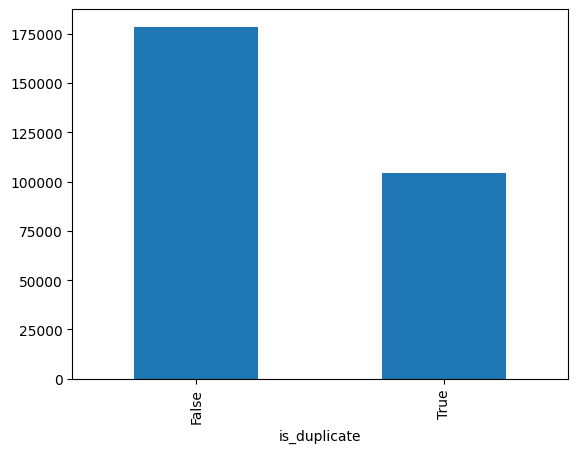

In [ ]:
new_df_train['is_duplicate'].value_counts().plot(kind='bar')

<Axes: xlabel='is_duplicate'>

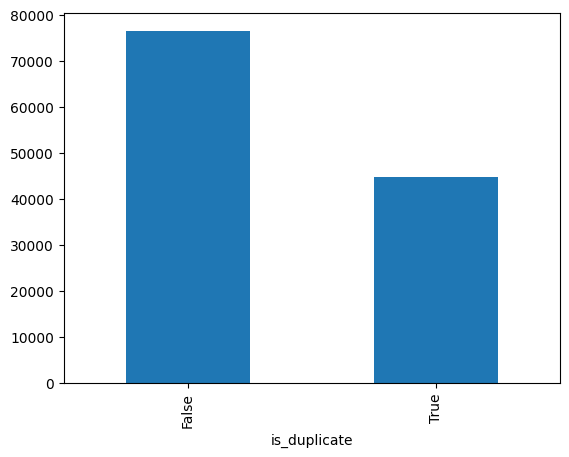

In [ ]:
new_df_test['is_duplicate'].value_counts().plot(kind='bar')


In [ ]:
# Repeated question in train dataset
qid = pd.Series(new_df_train['text_question1'].tolist() + new_df_train['text_question2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])


Number of unique questions 403284
Number of questions getting repeated 73299


In [ ]:
# Repeated question in test dataset
qid = pd.Series(new_df_test['text_question1'].tolist() + new_df_test['text_question2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 196769
Number of questions getting repeated 24901


## **Feature Engineering**

Let us now construct a few features like:

freq_qid1 = Frequency of qid1's
freq_qid2 = Frequency of qid2's
q1len = Length of q1
q2len = Length of q2
q1_n_words = Number of words in Question 1
q2_n_words = Number of words in Question 2
word_Common = (Number of common unique words in Question 1 and Question 2)
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
word_share = (word_common)/(word_Total)
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [ ]:
#Feature engineering
df = new_df_train.sample(10000)
df['freq_qid1'] = df.groupby('text_question1')['text_question2'].transform('count')
df['freq_qid2'] = df.groupby('text_question2')['text_question2'].transform('count')
df['q1len'] = df['text_question1'].str.len()
df['q2len'] = df['text_question2'].str.len()
df['q1_words'] = df['text_question1'].apply(lambda x: len(x.split(" ")))
df['q2_words'] = df['text_question2'].apply(lambda x: len(x.split(" ")))

def normalized_word_count(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text_question2'].split(" ")))
    return 1.0 * (len(w1 & w2))
df['word_common'] = df.apply(normalized_word_count, axis = 1)


def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text_question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text_question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])



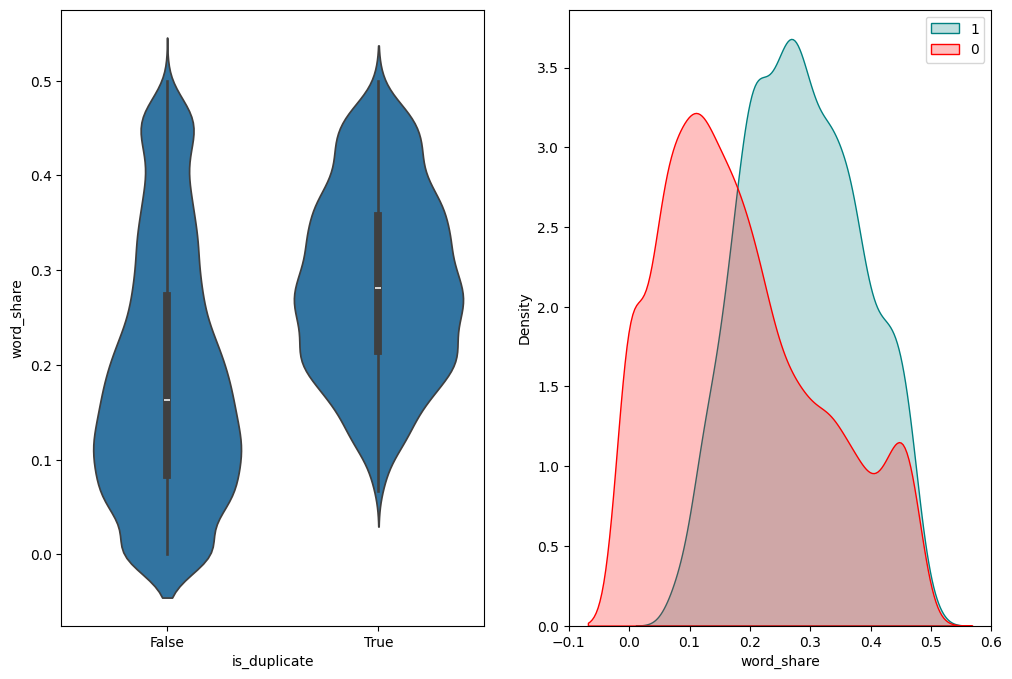

In [ ]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "is_duplicate", y = "word_share", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_share'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['is_duplicate'] == 0]['word_share'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

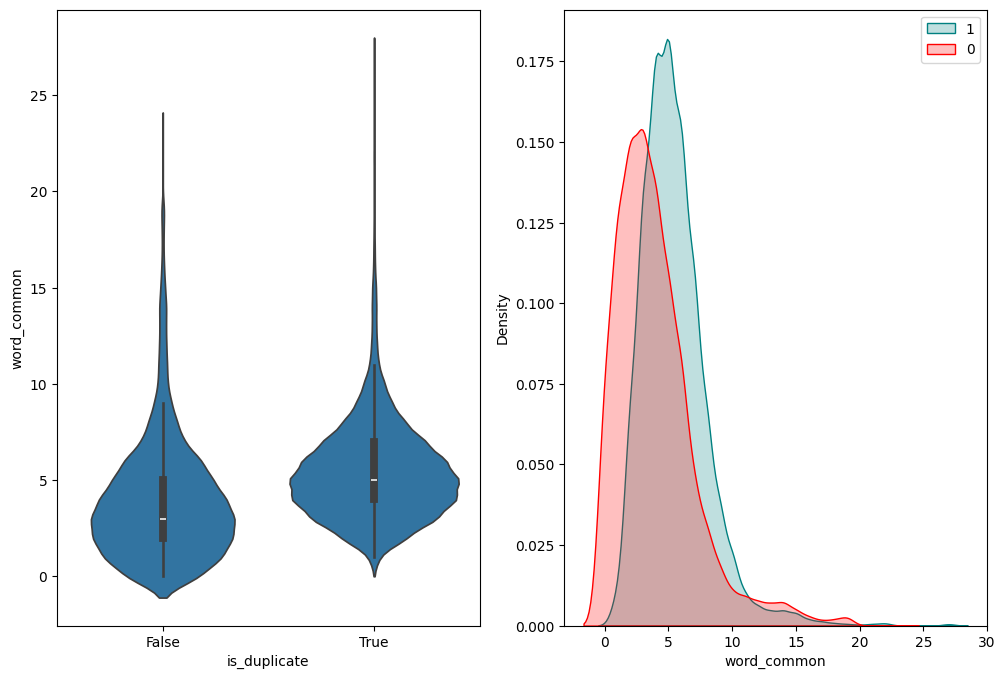

In [ ]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "is_duplicate", y = "word_common", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_common'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['is_duplicate'] == 0]['word_common'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

Both of the plots presented in the analysis suggest that there is significant overlap between the distributions of the word_Common feature in similar and non-similar questions. This means that the word_Common feature alone may not be a strong enough indicator to determine whether two questions are similar or not. It is important to take into account other features as well when building models for identifying duplicate questions, in order to achieve a high level of accuracy.

## **Pre-processing of data**

In [8]:
#Pre-processing of data
def preprocess_data(text):
    # convert to string
    text = str(text)
    # lowercase
    text = text.lower()
    # remove contractions
    text = contractions.fix(text)
    # remove hashtags
    text = re.sub(r'#(\w+)','',text)
    # remove special characters
    text = re.sub(r'[^\w ]+','',text)
    # remove links if any
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    # remove non-ascii
    text = ''.join(word for word in text if ord(word) < 128)
    # remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove digits
    text = re.sub(r'[\d]+','',text)
    # remove single letters
    text = ' '.join(word for word in text.split() if len(word) > 1)
    # remove multiple spaces
    text = ' '.join(text.split())

    return text

Applying pre-process data to train data

In [9]:
df_preprocess_train = new_df_train.copy() # Create a copy of the original dataframe

#change the name to df_train_preprocess
df_preprocess_train.loc[:,"text_question1"] = df_preprocess_train["text_question1"].apply(preprocess_data)
df_preprocess_train.loc[:,"text_question2"] = df_preprocess_train["text_question2"].apply(preprocess_data)
df_preprocess_train.head()

,text_question1,text_question2,is_duplicate
0,how do gain healthy weight without eating junk,what are the healthy ways of gaining weight an...,True
1,what is unusual or different about the food an...,what is unusual or different about the food an...,False
2,how can make music player with sensor in android,how can make music player for android,False
3,how much can you charge for website,how much can charge for website,True
4,how can treat swollen clitoris,how do you treat swollen tongue,False


Applying pre-process data to test data

In [10]:
df_preprocess_test = new_df_test.copy() # Create a copy of the original dataframe
df_preprocess_test.loc[:,"text_question1"] = df_preprocess_test["text_question1"].apply(preprocess_data)
df_preprocess_test.loc[:,"text_question2"] = df_preprocess_test["text_question2"].apply(preprocess_data)
df_preprocess_test.head()



,text_question1,text_question2,is_duplicate
0,was it appropriate for meryl streep to use her...,should meryl streep be using her position to a...,True
1,have forgot the screen unlock pin code of my h...,how do unlock my htc,False
2,what book do you want to read,how do you choose what books you read,False
3,how do you know what is true and what is not,how do we know what is true and what is not,True
4,have seen bald men treated equally as others i...,what do indian guys think of beautiful bald girls,False


### **TF-IDF Vectorizer**

In [ ]:
# Fit Tfidf Vectorizer of train & test dataset

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(df_preprocess_train['text_question1']+' '+df_preprocess_train['text_question2'])

#no. of feature
test_tfidf = tfidf.transform(df_preprocess_test['text_question1']+' '+df_preprocess_test['text_question2'])

train_tfidf.shape,test_tfidf.shape

((283003, 82815), (121287, 82815))

### **XGBclassification**

In [ ]:

labels = df_preprocess_train['is_duplicate']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(train_tfidf,labels)

predictions_train=model_xgb.predict(train_tfidf)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(df_preprocess_train['is_duplicate'],predictions_train))
print("Classification Report:\n", classification_report(df_preprocess_train['is_duplicate'],predictions_train))

predictions_test = model_xgb.predict(test_tfidf)
predictions_test = list(predictions_test)


print('Test Accuracy score:',accuracy_score(df_preprocess_test['is_duplicate'],predictions_test))
print("Classification Report:\n", classification_report(df_preprocess_test['is_duplicate'],predictions_test))

Train Accuracy score: 0.7662568948032353
Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.90      0.83    178519
        True       0.76      0.54      0.63    104484

    accuracy                           0.77    283003
   macro avg       0.76      0.72      0.73    283003
weighted avg       0.76      0.77      0.76    283003

Test Accuracy score: 0.7507729600039575
Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.88      0.82     76508
        True       0.73      0.52      0.61     44779

    accuracy                           0.75    121287
   macro avg       0.74      0.70      0.71    121287
weighted avg       0.75      0.75      0.74    121287



## **Word2Vec**

## Word2Vec using word tokenization on train data

In [ ]:
# Assuming 'processed_questions' contains preprocessed text
X = df_preprocess_train[['text_question1', 'text_question2']]
y = df_preprocess_train['is_duplicate']

# Tokenize the sentences
tokenized_sentences_q1 = X['text_question1'].apply(lambda x: str(x).split())
tokenized_sentences_q2 = X['text_question2'].apply(lambda x: str(x).split())

In [ ]:
# Train Word2Vec model
word2vec_model_q1 = Word2Vec(sentences=tokenized_sentences_q1, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model_q2 = Word2Vec(sentences=tokenized_sentences_q2, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the vector representation of a sentence
def get_sentence_vector(sentence, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Create feature vectors for each question
X_q1 = np.array([get_sentence_vector(sentence, word2vec_model_q1) for sentence in tokenized_sentences_q1])
X_q2 = np.array([get_sentence_vector(sentence, word2vec_model_q2) for sentence in tokenized_sentences_q2])

# Concatenate the feature vectors
X_combined = np.concatenate((X_q1, X_q2), axis=1)

labels = df_preprocess_train['is_duplicate']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined,labels)


predictions_train=model_xgb.predict(X_combined)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(df_preprocess_train['is_duplicate'],predictions_train))
print("Classification Report:\n", classification_report(df_preprocess_train['is_duplicate'],predictions_train))


Train Accuracy score: 0.8081151083204065
Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.90      0.86    178519
        True       0.80      0.64      0.71    104484

    accuracy                           0.81    283003
   macro avg       0.80      0.77      0.78    283003
weighted avg       0.81      0.81      0.80    283003



## Word2Vec using word tokenization on test data

In [ ]:

# Assuming 'processed_questions' contains preprocessed text
X = df_preprocess_test[['text_question1', 'text_question2']]
y = df_preprocess_test['is_duplicate']

# Tokenize the sentences
tokenized_sentences_q1 = X['text_question1'].apply(lambda x: str(x).split())
tokenized_sentences_q2 = X['text_question2'].apply(lambda x: str(x).split())



In [ ]:
# Train Word2Vec model
word2vec_model_q1 = Word2Vec(sentences=tokenized_sentences_q1, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model_q2 = Word2Vec(sentences=tokenized_sentences_q2, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the vector representation of a sentence
def get_sentence_vector(sentence, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Create feature vectors for each question
X_q1 = np.array([get_sentence_vector(sentence, word2vec_model_q1) for sentence in tokenized_sentences_q1])
X_q2 = np.array([get_sentence_vector(sentence, word2vec_model_q2) for sentence in tokenized_sentences_q2])

# Concatenate the feature vectors
X_combined = np.concatenate((X_q1, X_q2), axis=1)


labels = df_preprocess_test['is_duplicate']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined,labels)


predictions_test=model_xgb.predict(X_combined)
predictions_test = list(predictions_test)
print('Test Accuracy score:',accuracy_score(df_preprocess_test['is_duplicate'],predictions_test))
print("Classification Report:\n", classification_report(df_preprocess_test['is_duplicate'],predictions_test))


Test Accuracy score: 0.8407248921978447
Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.92      0.88     76508
        True       0.84      0.70      0.76     44779

    accuracy                           0.84    121287
   macro avg       0.84      0.81      0.82    121287
weighted avg       0.84      0.84      0.84    121287



## **SBERT**

In [ ]:
#Load pre-trained model
model_name = 'paraphrase-distilroberta-base-v2'
model = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## **SBERT applied on sample train data**

In [ ]:
sample_size = 3000  # Adjust as needed
sampled_df = new_df_train.sample(n=sample_size, random_state=52)

# Encode questions using SBERT model
question1_embeddings = model.encode(sampled_df['text_question1'].tolist())
question2_embeddings = model.encode(sampled_df['text_question2'].tolist())


X_combined = np.concatenate((question1_embeddings, question2_embeddings), axis=1)

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values


model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined,labels)


predictions_train=model_xgb.predict(X_combined)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(sampled_df['is_duplicate'],predictions_train))
print("Classification Report:\n", classification_report(sampled_df['is_duplicate'],predictions_train))


Train Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1875
        True       1.00      1.00      1.00      1125

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



## **SBERT applied on sample test data**

In [ ]:
sample_size = 3000  # Adjust as needed
sampled_df = new_df_test.sample(n=sample_size, random_state=52)
#sampled_df=new_df_train


# Encode questions using SBERT model
question1_embeddings = model.encode(sampled_df['text_question1'].tolist())
question2_embeddings = model.encode(sampled_df['text_question2'].tolist())


X_combined = np.concatenate((question1_embeddings, question2_embeddings), axis=1)

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values


model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined,labels)


predictions_test=model_xgb.predict(X_combined)
predictions_test = list(predictions_test)
print('Test Accuracy score:',accuracy_score(sampled_df['is_duplicate'],predictions_test))
print("Classification Report:\n", classification_report(sampled_df['is_duplicate'],predictions_test))

Test Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1900
        True       1.00      1.00      1.00      1100

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



##**GloVe**

###  Load SpaCy  for tokenization

In [ ]:
nlp = spacy.load("en_core_web_md")

### Load GloVe embeddings

In [ ]:



def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

glove_embeddings = load_glove_embeddings('/content/drive/My Drive/glove.6B.100d.txt')

### Function to embed questions using SpaCy and GloVe on train data

In [ ]:
def embed_question(question, model):
    tokens = [token.vector for token in model(question)]
    return np.mean(tokens, axis=0)

sample_size = 1000  # Adjust as needed
sampled_df = df_preprocess_train.sample(n=sample_size, random_state=42)
# Function to calculate cosine similarity between two embeddings
def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

    # Preprocess the data and create embeddings for each question pair
embeddings = []
labels = []
for idx, row in sampled_df.iterrows():
    q1_embedding = embed_question(row['text_question1'], nlp)
    q2_embedding = embed_question(row['text_question2'], nlp)
    combined_embedding = np.abs(q1_embedding - q2_embedding)  # Combine embeddings
    embeddings.append(combined_embedding)
    labels.append(row['is_duplicate'])

In [ ]:


model_xgb = xgb.XGBClassifier()
model_xgb.fit(embeddings,labels)


predictions_train=model_xgb.predict(embeddings)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(sampled_df['is_duplicate'],predictions_train))
print("Classification Report:\n", classification_report(sampled_df['is_duplicate'],predictions_train))

Train Accuracy score: 0.989
Classification Report:
               precision    recall  f1-score   support

       False       0.98      1.00      0.99       631
        True       1.00      0.97      0.98       369

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



### Function to embed questions using SpaCy and GloVe on test data

In [ ]:

# Function to embed questions using SpaCy and GloVe
def embed_question(question, model):
    tokens = [token.vector for token in model(question)]
    return np.mean(tokens, axis=0)

sample_size = 1000  # Adjust as needed
sampled_df = df_preprocess_test.sample(n=sample_size, random_state=42)
# Function to calculate cosine similarity between two embeddings
def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

    # Preprocess the data and create embeddings for each question pair
embeddings = []
labels = []
for idx, row in sampled_df.iterrows():
    q1_embedding = embed_question(row['text_question1'], nlp)
    q2_embedding = embed_question(row['text_question2'], nlp)
    combined_embedding = np.abs(q1_embedding - q2_embedding)  # Combine embeddings
    embeddings.append(combined_embedding)
    labels.append(row['is_duplicate'])

In [ ]:

model_xgb = xgb.XGBClassifier()
model_xgb.fit(embeddings,labels)


predictions_test=model_xgb.predict(embeddings)
predictions_test = list(predictions_test)
print('Test Accuracy score:',accuracy_score(sampled_df['is_duplicate'],predictions_test))
print("Classification Report:\n", classification_report(sampled_df['is_duplicate'],predictions_test))

Test Accuracy score: 0.995
Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      1.00       653
        True       1.00      0.99      0.99       347

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



## **BERT**

In [14]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [16]:
# Sample size and load data
sample_size = 3000  # Adjust as needed
sampled_df = new_df_train.sample(n=sample_size, random_state=52)


# Tokenize questions using BERT tokenizer
question1_tokens = tokenizer(sampled_df['text_question1'].tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)
question2_tokens = tokenizer(sampled_df['text_question2'].tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)

# Define batch size
batch_size = 8

# Encode questions using BERT model with reduced batch size
question1_embeddings = []
question2_embeddings = []

for i in range(0, len(sampled_df), batch_size):
    batch_question1_tokens = {k: v[i:i+batch_size] for k, v in question1_tokens.items()}
    batch_question2_tokens = {k: v[i:i+batch_size] for k, v in question2_tokens.items()}

    # Encode questions using BERT model
    batch_question1_embeddings = bert_model(batch_question1_tokens)['pooler_output']
    batch_question2_embeddings = bert_model(batch_question2_tokens)['pooler_output']

    question1_embeddings.append(batch_question1_embeddings)
    question2_embeddings.append(batch_question2_embeddings)

# Concatenate question embeddings
question1_embeddings = tf.concat(question1_embeddings, axis=0)
question2_embeddings = tf.concat(question2_embeddings, axis=0)
X_combined = tf.concat([question1_embeddings, question2_embeddings], axis=1).numpy()

# Generate labels for the sampled data

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values

# Train Gradient Boosting Classifier

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined, labels)

# Predictions and evaluation
predictions_train = model_xgb.predict(X_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

Train Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1875
        True       1.00      1.00      1.00      1125

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [18]:
# Sample size and load data
sample_size = 3000  # Adjust as needed
sampled_df = new_df_test.sample(n=sample_size, random_state=52)


# Tokenize questions using BERT tokenizer
question1_tokens = tokenizer(sampled_df['text_question1'].tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)
question2_tokens = tokenizer(sampled_df['text_question2'].tolist(), padding=True, truncation=True, return_tensors='tf', max_length=128)

# Define batch size
batch_size = 8

# Encode questions using BERT model with reduced batch size
question1_embeddings = []
question2_embeddings = []

for i in range(0, len(sampled_df), batch_size):
    batch_question1_tokens = {k: v[i:i+batch_size] for k, v in question1_tokens.items()}
    batch_question2_tokens = {k: v[i:i+batch_size] for k, v in question2_tokens.items()}

    # Encode questions using BERT model
    batch_question1_embeddings = bert_model(batch_question1_tokens)['pooler_output']
    batch_question2_embeddings = bert_model(batch_question2_tokens)['pooler_output']

    question1_embeddings.append(batch_question1_embeddings)
    question2_embeddings.append(batch_question2_embeddings)

# Concatenate question embeddings
question1_embeddings = tf.concat(question1_embeddings, axis=0)
question2_embeddings = tf.concat(question2_embeddings, axis=0)
X_combined = tf.concat([question1_embeddings, question2_embeddings], axis=1).numpy()

# Generate labels for the sampled data

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values

# Train Gradient Boosting Classifier

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_combined, labels)

# Predictions and evaluation
predictions_test = model_xgb.predict(X_combined)
print('Test Accuracy score:', accuracy_score(labels, predictions_test))
print("Classification Report:\n", classification_report(labels, predictions_test))

Test Accuracy score: 1.0
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      1900
        True       1.00      1.00      1.00      1100

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

